In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Get some data
DATA_DIR = './data/'
try:
    cleaned_data = pd.read_csv(
        DATA_DIR+'cleaned_data.csv',
        index_col=0,
        names=['cleaned_tweets', 'sentiment']
    )
except:
    data = pd.read_csv(
        DATA_DIR + "training.1600000.processed.noemoticon.csv",
        index_col=2,
        names=['polarity', 'tweet_id', 'query', 'user', 'tweet_text'],
        encoding='latin-1'
    )

## Clean Data

In [5]:
import re
import string
from nltk.stem import PorterStemmer

class DataCleaner(object):
    def __init__(self, data, **params):
        """ Data should be a pandas Series object"""
        self.data = data
        self.params = params.copy()
        self.stemmer = PorterStemmer()
        
    def _fill_urls(self, tweet_text):
        return re.sub(r"http\S+", 'URL', tweet_text)
    
    def _fill_usernames(self, tweet_text):
        return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)', 'USERNAME', tweet_text)

    def _truncate_extra_letters(self, tweet_text):
        return re.sub(r'(.)\1+', r'\1\1', tweet_text)
    
    def _remove_punctuation(self, tweet_text):
        return re.sub('['+string.punctuation.replace('#', '')+']', '', tweet_text)
    
    def _fill_hashtags(self, tweet_text):
        return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)', 'HASHTAG', tweet_text)
    
    def _tokenize(self, tweet_text):
        return tweet_text.split()
    
    def _stem_word_list(self, word_list):
        return [self.stemmer.stem(word) for word in word_list]

    def clean_data(self):
        data = self.data.copy()
        data = data.apply(self._fill_urls)
        data = data.apply(self._fill_usernames)
        data = data.apply(self._truncate_extra_letters)
        data = data.apply(self._remove_punctuation)
        if not self.params['keep_hashtags']:
            data = data.apply(self._fill_hashtags)
        data = data.apply(self._tokenize)
        data = data.apply(self._stem_word_list)
        return data

In [6]:
data_cleaner = DataCleaner(data.tweet_text, keep_hashtags=False)

In [7]:
cleaned_tweets = data_cleaner.clean_data()
cleaned_tweets.name = 'cleaned_tweets'
sentiment = data.polarity[data.polarity != 2]
cleaned_tweets = cleaned_tweets[sentiment != 2]
sentiment.name = 'sentiment'

In [8]:
cleaned_data = pd.concat([cleaned_tweets, sentiment], axis=1)
cleaned_data.to_csv(DATA_DIR+'cleaned_data.csv')

In [5]:
data = data[data['polarity'] != 2] # remove neutral observations
data = data[~data['tweet_text'].str.startswith('RT')] # remove retweets

In [6]:
no_hashtags['tweet_text'] = no_hashtags['tweet_text'].apply(tokenize_no_tags)
data['tweet_text'] = data['tweet_text'].apply(tokenize)

### Process Text Features

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm

In [33]:
max_features=3000

In [34]:
# Tokenize data
# Three different vectorizers to try out the merits of different sets of ngrams
unigram_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    stop_words='english',
    max_features=max_features
)
bigram_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(2, 2),
    stop_words='english',
    max_features=max_features
)
both_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    stop_words='english',
    max_features=max_features
)

In [35]:
unigram_data = unigram_vectorizer.fit_transform(data['tweet_text'].values)
bigram_data = bigram_vectorizer.fit_transform(data['tweet_text'].values)
both_data = both_vectorizer.fit_transform(data['tweet_text'].values)

In [39]:
X_train_uni, X_test_uni, Y_train_uni, Y_test_uni = train_test_split(unigram_data, data['polarity'].values, test_size=0.40)
X_train_bi, X_test_bi, Y_train_bi, Y_test_bi = train_test_split(bigram_data, data['polarity'].values, test_size=0.40)
X_train_both, X_test_both, Y_train_both, Y_test_both = train_test_split(both_data, data['polarity'].values, test_size=0.40)

## Logistic Regression

In [40]:
uni_logistic = LogisticRegression(fit_intercept=True)
bi_logistic = LogisticRegression(fit_intercept=True)
logistic = LogisticRegression(fit_intercept=True)

In [364]:
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

In [41]:
uni_logistic.fit(X_train_uni, Y_train_uni)
bi_logistic.fit(X_train_bi, Y_train_bi)
logistic.fit(X_train_both, Y_train_both)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
print("In-sample")
print("Unigrams only: ", uni_logistic.score(X_train_uni, Y_train_uni))
print("Bigrams only: ", bi_logistic.score(X_train_bi, Y_train_bi))
print("Both: ", logistic.score(X_train_both, Y_train_both))

In-sample
Unigrams only:  0.766415625
Bigrams only:  0.647405208333
Both:  0.766358333333


In [43]:
print("Out-of-sample")
print("Unigrams only: ", uni_logistic.score(X_test_uni, Y_test_uni))
print("Bigrams only: ", bi_logistic.score(X_test_bi, Y_test_bi))
print("Both: ", logistic.score(X_test_both, Y_test_both))

Out-of-sample
Unigrams only:  0.7642828125
Bigrams only:  0.645959375
Both:  0.765353125


## SVM

In [44]:
from sklearn import svm

In [45]:
# SVMs scale quadratically with number of observations
# using the LinearSVC reduces the training time by a massive amount
uni_vector_machine = svm.LinearSVC()
bi_vector_machine = svm.LinearSVC()
vector_machine = svm.LinearSVC()
#svm.SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)

In [46]:
uni_vector_machine.fit(X_train_uni, Y_train_uni)
bi_vector_machine.fit(X_train_bi, Y_train_bi)
vector_machine.fit(X_train_both, Y_train_both)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [47]:
print("In-sample")
print("Unigrams only: ", uni_vector_machine.score(X_train_uni, Y_train_uni))
print("Bigrams only: ", bi_vector_machine.score(X_train_bi, Y_train_bi))
print("Both: ", vector_machine.score(X_train_both, Y_train_both))

In-sample
Unigrams only:  0.765683333333
Bigrams only:  0.647241666667
Both:  0.765641666667


In [48]:
print("Out-of-sample")
print("Unigrams only: ", uni_vector_machine.score(X_test_uni, Y_test_uni))
print("Bigrams only: ", bi_vector_machine.score(X_test_bi, Y_test_bi))
print("Both: ", vector_machine.score(X_test_both, Y_test_both))

Out-of-sample
Unigrams only:  0.7637734375
Bigrams only:  0.6457921875
Both:  0.7645859375


## Neural Networks

In [9]:
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Dropout, Activation, LSTM
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [10]:
import gensim
from gensim.models.word2vec import Word2Vec

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
EMBEDDING_DIM = 200
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 30

In [13]:
cleaned_data.head()

,cleaned_tweets,sentiment
Mon Apr 06 22:19:45 PDT 2009,"[usernam, url, aww, that, a, bummer, you, shou...",0
Mon Apr 06 22:19:49 PDT 2009,"[is, upset, that, he, cant, updat, hi, faceboo...",0
Mon Apr 06 22:19:53 PDT 2009,"[usernam, I, dive, mani, time, for, the, ball,...",0
Mon Apr 06 22:19:57 PDT 2009,"[my, whole, bodi, feel, itchi, and, like, it, ...",0
Mon Apr 06 22:19:57 PDT 2009,"[usernam, no, it, not, behav, at, all, im, mad...",0


In [14]:
cleaned_tweets = cleaned_data.cleaned_tweets.values
sentiment = cleaned_data.sentiment.values

In [15]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(np.array(cleaned_tweets), np.array(sentiment), test_size=0.3)

In [ ]:
"""def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in enumerate(tweets):
        label = '%s_%s'%(label_type,i)
        labelized.append(gensim.models.doc2vec.LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')
#x_train = [gensim.models.doc2vec.LabeledSentence(x, ['TRAIN']) for x in x_train]
#x_test = [gensim.models.doc2vec.LabeledSentence(x, ['TEST']) for x in x_test]"""

In [18]:
class Word2VecModelBuilder(object):
    def __init__(self, data, embedding_dim, min_count):
        """Data is a list of gensim LabeledSentence objects"""
        self.data = data.copy()
        self.embedding_dim = embedding_dim
        self.min_count = min_count
        self.w2v = Word2Vec(size=self.embedding_dim, min_count=self.min_count)
    
    def label_tweets(self, tweets, label):
        labelized = []
        for i, v in enumerate(tweets):
            label = "%s_%s" % (label, i)
            labelized.append(gensim.models.doc2vec.LabeledSentence(v, [label]))
        return labelized
    
    def _build_vocab(self, corpus):
        self.w2v.build_vocab([obs.words for obs in corpus])
        
    def _train(self, corpus):
        self.w2v.train(
            [obs.words for obs in corpus],
            total_examples=len(corpus),h
            epochs=self.w2v.iter
        )
    
    def build_model(self, corpus):
        self._build_vocab(corpus)
        self._train(corpus)
        return self.w2v

def build_w2v(data, embedding_dim, min_count, label='TRAIN'):
    w2v_builder = Word2VecModelBuilder(x_train, embedding_dim, min_count)
    labeled_tweets = w2v_builder.label_tweets(data, label)
    w2v = w2v_builder.build_model(labeled_tweets)
    return w2v

In [ ]:
w2v = build_w2v(x_train, EMBEDDING_DIM, 10, 'TRAIN')

In [ ]:
w2v

In [20]:
w2v.most_similar('bless')

[('prais', 0.6132292747497559),
 ('prayer', 0.510169267654419),
 ('presenc', 0.5029248595237732),
 ('grate', 0.4882550835609436),
 ('cherish', 0.48216116428375244),
 ('burden', 0.4652221202850342),
 ('sweetheart', 0.45617178082466125),
 ('thank', 0.4491913914680481),
 ('hug', 0.43353497982025146),
 ('inspir', 0.4314134120941162)]

In [164]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data.tweet_text.values) 
train_tokens = tokenizer.texts_to_sequences(x_train.)
test_tokens = 

In [165]:
sequences = pad_sequences(tokens, maxlen=MAX_SEQUENCE_LENGTH)

In [134]:
nb_words = min(MAX_NB_WORDS, len(tokenizer.word_index)+1)

In [132]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [137]:
"""model = Sequential()
model.add(
    Embedding(
        nb_words,
        EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH
    )
)
model.add(
    LSTM(
        num_lstm,
        dropout=rate_drop_lstm,
        recurrent_dropout=rate_drop_lstm
    )
)"""
"""model.add(Dense(128, input_dim=max_features), activation='relu')
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())"""

"model.add(Dense(128, input_dim=max_features), activation='relu')\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nprint(model.summary())"

In [150]:
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in word_vectors.vocab:
        embedding_matrix[i] = word_vectors.word_vec(word)

In [155]:
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(
    num_lstm,
    dropout=rate_drop_lstm,
    recurrent_dropout=rate_drop_lstm
)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_input)
x = lstm_layer(embedded_sequences_1)

x = Dropout(rate_drop_dense)(x)
x = BatchNormalization()(x)

x = Dense(num_dense, activation='relu')(x)
x = Dropout(rate_drop_dense)(x)
x = BatchNormalization()(x)

preds = Dense(1, activation='sigmoid')(x)

In [156]:
model = Model(
    inputs=sequence_input,
    outputs=preds
)
model.compile(
    loss='binary_crossentropy',
    optimizer='nadam',
    metrics=['acc']
)

In [157]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 30, 200)           40000000  
_________________________________________________________________
lstm_5 (LSTM)                (None, 190)               297160    
_________________________________________________________________
dropout_3 (Dropout)          (None, 190)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 190)               760       
_________________________________________________________________
dense_1 (Dense)              (None, 147)               28077     
_________________________________________________________________
dropout_4 (Dropout)          (None, 147)               0         
__________

In [ ]:
hist = model.fit(
    x=sequences,
    y=y_train
)

In [20]:
def batch_generator(X, y, batch_size):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [ ]:
batch_size=128
model.fit_generator(
    generator=batch_generator(X_train, Y_train, batch_size),
    epochs=4, 
    samples_per_epoch=X_train.shape[0]
)
scores = model.evaluate(X_test.toarray(), Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [29]:
model.fit(X_train.toarray(), Y_train, validation_data=(X_test.toarray(), Y_test), epochs=4, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test.toarray(), Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 76.47%


In [33]:
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dropout

In [47]:
conv_model = Sequential()
conv_model.add(
    Conv1D(
        filters=256,
        kernel_size=16,
        padding='valid',
        activation='relu',
        strides=1,
        input_shape=(max_features, 1)
    )
)
conv_model.add(GlobalAveragePooling1D())
conv_model.add(Dropout(0.25))

conv_model.add(Dense(256, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(16, activation='relu'))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 2985, 256)         4352      
_________________________________________________________________
global_average_pooling1d_8 ( (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total para

In [ ]:
conv_model.fit(
    X_train.toarray()[:,:,None],
    Y_train,
    validation_data=(X_test.toarray()[:,:,None], Y_test),
    epochs=4,
    batch_size=128,
    verbose=2
)
# Final evaluation of the model
conv_scores = conv_model.evaluate(X_test.toarray(), Y_test, verbose=0)
print("Accuracy: %.2f%%" % (conv_scores[1]*100))

## Introduce Trump Data

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [341]:
trump_tweets = pd.read_csv('./realDonaldTrump_tweets.csv', index_col=1)

In [342]:
trump_tweets = trump_tweets[~trump_tweets['text'].str.startswith('RT')]
trump_tweets['original_text'] = trump_tweets['text']
trump_tweets['text'] = trump_tweets['text'].apply(tokenize)

In [343]:
trump_tweets.index = pd.DatetimeIndex(pd.to_datetime(trump_tweets.index).tz_localize('UTC'))

In [344]:
trump_tweets = trump_tweets.tz_convert('EST')

In [345]:
#trump_tweets_cleaned = vectorizer.transform(trump_tweets['text'].values)
trump_tweets_cleaned = both_vectorizer.transform(trump_tweets['text'].values)

In [346]:
trump_tweets['sentiment'] = logistic.predict(trump_tweets_cleaned)
trump_tweets['sentiment_prob'] = logistic.predict_proba(trump_tweets_cleaned)[:,1]

In [347]:
trump_tweets['svm_sentiment'] = vector_machine.predict(trump_tweets_cleaned)
trump_tweets['svm_sentiment_prob'] = vector_machine.predict_proba(trump_tweets_cleaned)[:,1] # no built-in probability

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

## Compare Logistic and SVM

In [348]:
logistic_predictions = logistic.predict(trump_tweets_cleaned)
svm_predictions = vector_machine.predict(trump_tweets_cleaned)

In [349]:
print('SVM and Logistic Model Agreement: ', (logistic_predictions == svm_predictions).sum()/len(logistic_predictions))

SVM and Logistic Model Agreement:  0.990705679862


In [350]:
from sklearn.metrics import confusion_matrix, classification_report

In [351]:
# Logistic Confusion Matrix
confusion_matrix(Y_test_both, logistic.predict(X_test_both))

array([[235822,  83749],
       [ 66425, 254004]])

In [352]:
# SVM Confusion Matrix
confusion_matrix(Y_test_both, vector_machine.predict(X_test_both))

array([[234202,  85369],
       [ 65296, 255133]])

In [353]:
# Logistic Classification Report
print(classification_report(Y_test_both, logistic.predict(X_test_both)))

             precision    recall  f1-score   support

          0       0.78      0.74      0.76    319571
          4       0.75      0.79      0.77    320429

avg / total       0.77      0.77      0.77    640000



In [354]:
# SVM Classification Report
print(classification_report(Y_test_both, vector_machine.predict(X_test_both)))

             precision    recall  f1-score   support

          0       0.78      0.73      0.76    319571
          4       0.75      0.80      0.77    320429

avg / total       0.77      0.76      0.76    640000



## Start Playing with Results

In [356]:
trump_tweets_phones = trump_tweets[
    (trump_tweets.source=='Twitter for Android')|
    (trump_tweets.source=='Twitter for iPhone')
]

In [357]:
trump_tweets.index

DatetimeIndex(['2017-09-18 08:16:17-05:00', '2017-09-18 08:14:46-05:00',
               '2017-09-17 08:00:05-05:00', '2017-09-17 07:28:08-05:00',
               '2017-09-17 06:57:20-05:00', '2017-09-17 06:53:35-05:00',
               '2017-09-17 06:40:16-05:00', '2017-09-16 18:04:03-05:00',
               '2017-09-16 17:40:23-05:00', '2017-09-15 18:54:00-05:00',
               ...
               '2016-07-24 15:20:57-05:00', '2016-07-24 08:30:59-05:00',
               '2016-07-24 08:27:56-05:00', '2016-07-24 07:30:15-05:00',
               '2016-07-24 07:15:51-05:00', '2016-07-24 06:56:43-05:00',
               '2016-07-24 06:25:06-05:00', '2016-07-24 06:16:15-05:00',
               '2016-07-23 19:38:47-05:00', '2016-07-23 17:13:39-05:00'],
              dtype='datetime64[ns, EST]', name='created_at', length=2905, freq=None)

In [361]:
X = trump_tweets.groupby([trump_tweets.index.hour]).sentiment_prob.describe()
X

,count,mean,std,min,25%,50%,75%,max
created_at,,,,,,,,
0,18.0,0.652076,0.269504,0.054512,0.522236,0.691398,0.903960,0.960920
1,10.0,0.849322,0.136393,0.583424,0.806375,0.909007,0.947190,0.970741
2,9.0,0.633614,0.265019,0.049701,0.546338,0.650947,0.807577,0.899488
3,4.0,0.509872,0.260436,0.123571,0.480826,0.612153,0.641199,0.691613
4,13.0,0.496041,0.353693,0.028104,0.190124,0.581423,0.846724,0.967699
5,124.0,0.510014,0.250244,0.013196,0.295053,0.539477,0.699778,0.989381
6,217.0,0.517223,0.254935,0.007239,0.311139,0.525881,0.708154,0.987619
7,281.0,0.509927,0.246809,0.008119,0.308270,0.505104,0.725779,0.993544
8,252.0,0.509903,0.261669,0.003128,0.287486,0.511792,0.719548,0.987201


In [363]:
Y = trump_tweets_phones.groupby(
    [trump_tweets_phones.index.hour, trump_tweets_phones.source]
).sentiment_prob.describe()
Y

count      mean       std       min       25%  \
created_at source                                                               
0          Twitter for Android    6.0  0.468866  0.274354  0.054512  0.318764   
           Twitter for iPhone    12.0  0.743681  0.224886  0.262192  0.599953   
1          Twitter for Android    2.0  0.692456  0.154195  0.583424  0.637940   
           Twitter for iPhone     7.0  0.882443  0.115508  0.648883  0.856027   
2          Twitter for Android    1.0  0.611532       NaN  0.611532  0.611532   
           Twitter for iPhone     7.0  0.611917  0.296602  0.049701  0.508480   
3          Twitter for iPhone     3.0  0.449292  0.282348  0.123571  0.361741   
4          Twitter for Android    7.0  0.384602  0.326059  0.028104  0.134649   
           Twitter for iPhone     6.0  0.626053  0.367409  0.109302  0.347430   
5          Twitter for Android   22.0  0.577573  0.280629  0.096355  0.375547   
           Twitter for iPhone   102.0  0.495443  0.242238  0.013196  0.292037   
6          Twitter for Android  110.0  0.493026  0.271840  0.024980  0.253474   
           Twitter for iPhone   106.0  0.539466  0.234506  0.007239  0.379325   
7          Twitter for Android  123.0  0.461144  0.249619  0.008119  0.259088   
           Twitter for iPhone   156.0  0.543420  0.236506  0.035346  0.366955   
8          Twitter for Android  130.0  0.484890  0.257831  0.003128  0.265399   
           Twitter for iPhone   121.0  0.535245  0.264846  0.056514  0.289275   
9          Twitter for Android   53.0  0.501615  0.261083  0.011122  0.274543   
           Twitter for iPhone    90.0  0.608188  0.250627  0.038364  0.444180   
10         Twitter for Android   19.0  0.513017  0.264965  0.040026  0.301041   
           Twitter for iPhone    67.0  0.679374  0.243536  0.029530  0.530889   
11         Twitter for Android   18.0  0.552186  0.290108  0.046666  0.350232   
           Twitter for iPhone    82.0  0.698756  0.198272  0.140443  0.581314   
12         Twitter for Android   15.0  0.516428  0.265071  0.075495  0.312737   
           Twitter for iPhone    90.0  0.703226  0.238247  0.028067  0.561408   
13         Twitter for Android   14.0  0.485631  0.284132  0.096118  0.247216   
           Twitter for iPhone    84.0  0.667674  0.231033  0.036986  0.551068   
14         Twitter for Android    8.0  0.524498  0.368463  0.074331  0.224262   
           Twitter for iPhone   107.0  0.702154  0.242238  0.068961  0.585916   
15         Twitter for Android   27.0  0.526953  0.274461  0.115352  0.272582   
           Twitter for iPhone   111.0  0.682210  0.242891  0.014750  0.579227   
16         Twitter for Android   27.0  0.420874  0.277527  0.018420  0.195173   
           Twitter for iPhone   112.0  0.729006  0.199486  0.088912  0.630385   
17         Twitter for Android   29.0  0.497790  0.282113  0.034619  0.211242   
           Twitter for iPhone   131.0  0.677043  0.240121  0.016059  0.502636   
18         Twitter for Android   37.0  0.499577  0.246054  0.017636  0.331515   
           Twitter for iPhone    96.0  0.697434  0.242303  0.000967  0.586307   
19         Twitter for Android   39.0  0.585573  0.268360  0.051850  0.433992   
           Twitter for iPhone    81.0  0.696258  0.245434  0.084661  0.564062   
20         Twitter for Android   43.0  0.563528  0.227497  0.012704  0.427400   
           Twitter for iPhone    91.0  0.692277  0.230623  0.005564  0.545714   
21         Twitter for Android   43.0  0.575755  0.264303  0.025205  0.470997   
           Twitter for iPhone   115.0  0.664877  0.263819  0.028832  0.514538   
22         Twitter for Android   31.0  0.570841  0.280269  0.053574  0.323477   
           Twitter for iPhone    44.0  0.730426  0.230998  0.113000  0.634535   
23         Twitter for Android   15.0  0.688153  0.235628  0.307249  0.531844   
           Twitter for iPhone    29.0  0.815404  0.179472  0.422178  0.761558   

                                     50%       75%       max  

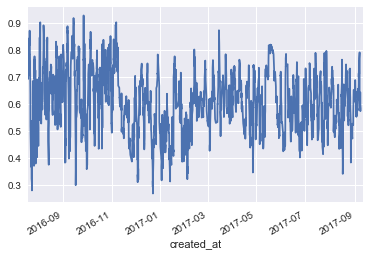

In [62]:
(trump_tweets.sentiment_prob.rolling(10).mean()).plot();

In [ ]:
trump_tweets.groupby([trump_tweets.index.day]).size()

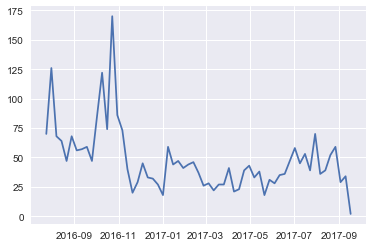

In [64]:
plt.plot(trump_tweets['text'].resample('W').count());

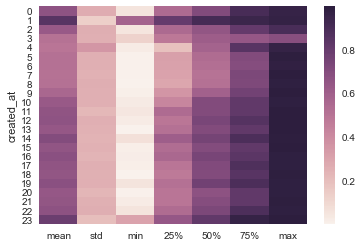

In [65]:
sns.heatmap(X[X.columns[1:]]);

In [415]:
phrase_and_coeff = {
    word : coefficient for word, coefficient in zip(
        [both_vectorizer.get_feature_names()[i] for i in np.argsort(np.abs(logistic.coef_[0]))[::-1]],
        logistic.coef_[0][np.argsort(np.abs(logistic.coef_[0]))[::-1]]
    )
}

In [416]:
phrase_and_coeff

{'sad': -9.2182198330019087,
 'sadly': -6.3743555303143689,
 'bummed': -5.8092480302927241,
 'poor': -5.6863417128506208,
 'unfortunately': -5.608669534056645,
 'miss': -5.5818421514559491,
 'wish luck': 5.550737086813549,
 'gutted': -5.3412093558365292,
 'hurts': -5.2337456871823829,
 'sucks': -5.1179404199776029,
 'wish': -5.1158990309731305,
 'sick': -5.0691271940225766,
 'disappointed': -4.9823502877440689,
 'missing': -4.9735974922397777,
 'depressing': -4.9416401745864249,
 'died': -4.8403583386997253,
 'air france': -4.7925270053683544,
 'ruined': -4.6552804629211995,
 'cancelled': -4.60542705530814,
 'headache': -4.5862893500836304,
 'lost help': -4.5578155039449895,
 'depressed': -4.5444810063102166,
 'upset': -4.4651004543916457,
 'bummer': -4.3976148292975346,
 'rip': -4.3482124299501521,
 'ugh': -4.3331325534038614,
 'won let': -4.3238516456242229,
 'farrah': -4.3221575844652449,
 'thank': 4.3147956949199431,
 'broke': -4.3030055874399871,
 'broken': -4.2153624674167816,
 '

In [70]:
top_ten_positive = list(
    zip(
        logistic.coef_[0][np.argsort(logistic.coef_[0])[-10::]],
        [both_vectorizer.get_feature_names()[i] for i in np.argsort(logistic.coef_[0])[-10::]]
    )
)
top_ten_negative = list(
    zip(
        logistic.coef_[0][np.argsort(logistic.coef_[0])[:10:]],
        [both_vectorizer.get_feature_names()[i] for i in np.argsort(logistic.coef_[0])[:10:]]
    )
)

In [71]:
top_ten_positive

[(3.4341104630506392, 'congrats'),
 (3.5537038325066566, 'blessed'),
 (3.590722152639831, 'congratulations'),
 (3.6211103008919663, 'smiling'),
 (3.7184968787675179, 'proud'),
 (3.8388748879890744, 'welcome'),
 (3.8526229389524924, 'smile'),
 (4.085113556581021, 'thanks'),
 (4.3147956949199431, 'thank'),
 (5.550737086813549, 'wish luck')]

In [72]:
top_ten_negative

[(-9.2182198330019087, 'sad'),
 (-6.3743555303143689, 'sadly'),
 (-5.8092480302927241, 'bummed'),
 (-5.6863417128506208, 'poor'),
 (-5.608669534056645, 'unfortunately'),
 (-5.5818421514559491, 'miss'),
 (-5.3412093558365292, 'gutted'),
 (-5.2337456871823829, 'hurts'),
 (-5.1179404199776029, 'sucks'),
 (-5.1158990309731305, 'wish')]

In [73]:
phrase_and_coeff[:10]

[(-9.2182198330019087, 'sad'),
 (-6.3743555303143689, 'sadly'),
 (-5.8092480302927241, 'bummed'),
 (-5.6863417128506208, 'poor'),
 (-5.608669534056645, 'unfortunately'),
 (-5.5818421514559491, 'miss'),
 (5.550737086813549, 'wish luck'),
 (-5.3412093558365292, 'gutted'),
 (-5.2337456871823829, 'hurts'),
 (-5.1179404199776029, 'sucks')]

# Visualizations

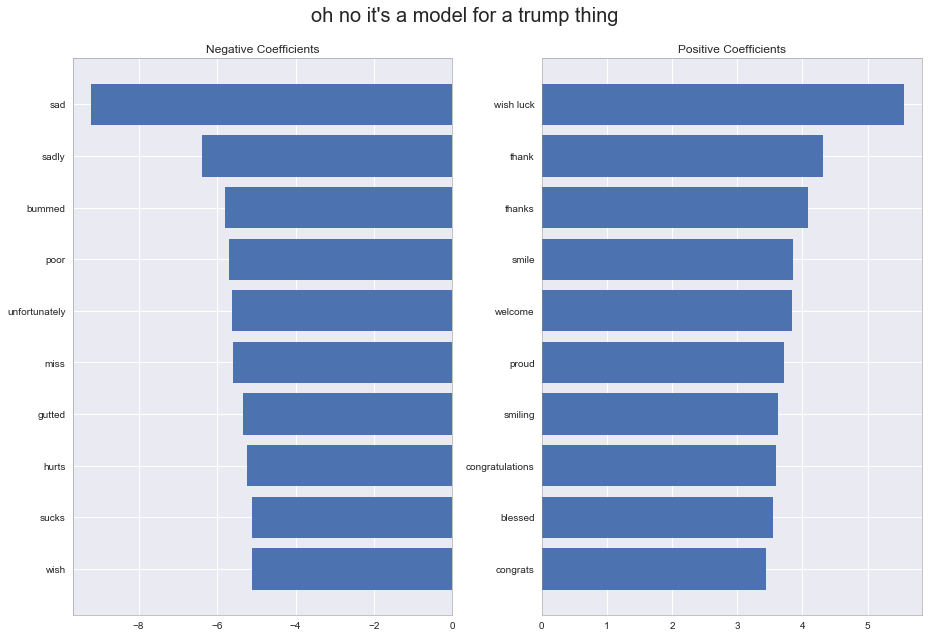

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(13, 9))
pos_coef, pos_grams = list(zip(*top_ten_positive))
neg_coef, neg_grams = list(zip(*top_ten_negative))

ax[0].barh(np.arange(len(neg_grams)), neg_coef[::-1])
ax[0].set_yticks(np.arange(len(neg_grams)))
ax[0].set_yticklabels(neg_grams[::-1])
ax[0].set_title('Negative Coefficients');

ax[1].barh(np.arange(len(pos_grams)), pos_coef)
ax[1].set_yticks(np.arange(len(pos_grams)))
ax[1].set_yticklabels(pos_grams)
#ax[1].yaxis.tick_right()
ax[1].set_title('Positive Coefficients');

plt.tight_layout();

fig.suptitle("oh no it's a model for a trump thing", fontsize=20)
fig.subplots_adjust(top=0.90)

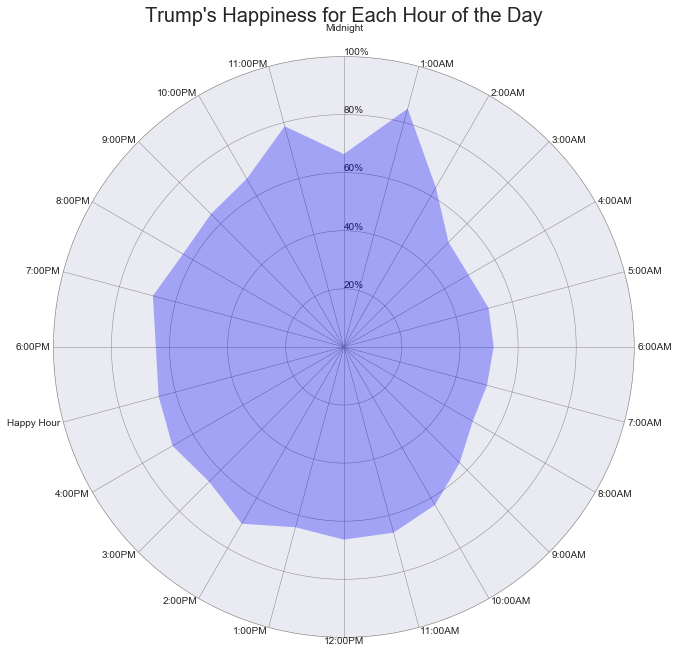

In [204]:
from math import pi
hours = ["Midnight", "1:00AM", "2:00AM", "3:00AM", "4:00AM", "5:00AM", "6:00AM", "7:00AM", "8:00AM",
         "9:00AM", "10:00AM", "11:00AM", "12:00PM", "1:00PM", "2:00PM", "3:00PM", "4:00PM", "Happy Hour",
         "6:00PM", "7:00PM", "8:00PM", "9:00PM", "10:00PM", "11:00PM"]
feelings = (100*trump_tweets.groupby([trump_tweets.index.hour]).sentiment_prob.mean().values).tolist()

N = len(hours)
x_as = [n/float(N)*2*pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
feelings += feelings[:1]
x_as += x_as[:1]

plt.figure(figsize=(9,9))

# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")

# Create polar plot
ax = plt.subplot(111, polar=True)
ax.set_title("Trump's Happiness for Each Hour of the Day", fontsize=20)

# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Set position of y-labels
ax.set_rlabel_position(0)

# Set color and linestyle of grid
ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)

# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Set yticks
plt.yticks([20, 40, 60, 80, 100], ["20%", "40%", "60%", "80%", "100%"])

# Plot data
ax.plot(x_as, feelings, linewidth=0, linestyle='solid', zorder=3)

# Fill area
ax.fill(x_as, feelings, 'b', alpha=0.3)


# Set axes limits
plt.ylim(0, 100)


# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi

    if angle_rad == 0:
        ha, distance_ax = "center", 10
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1

    ax.text(angle_rad, 100 + distance_ax, hours[i], size=10, horizontalalignment=ha, verticalalignment="center")

# Show polar plot
plt.tight_layout()
plt.show();

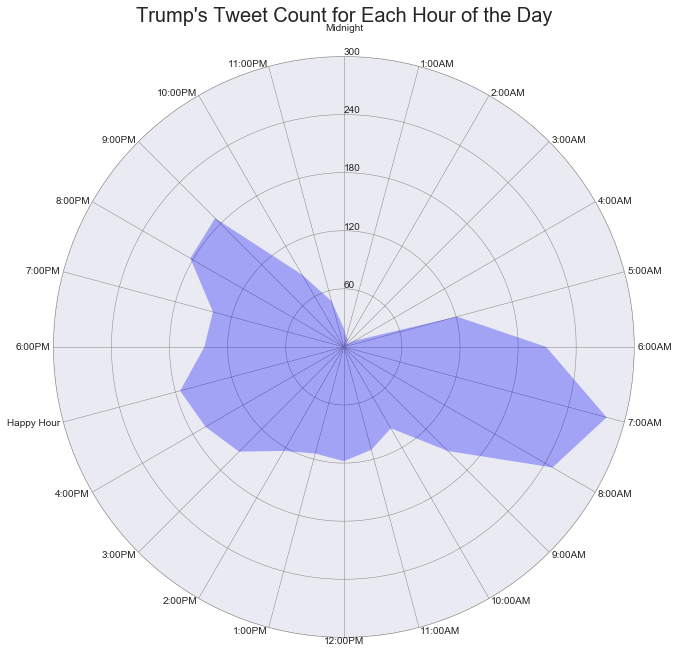

In [203]:
from math import pi
hours = ["Midnight", "1:00AM", "2:00AM", "3:00AM", "4:00AM", "5:00AM", "6:00AM", "7:00AM", "8:00AM",
         "9:00AM", "10:00AM", "11:00AM", "12:00PM", "1:00PM", "2:00PM", "3:00PM", "4:00PM", "Happy Hour",
         "6:00PM", "7:00PM", "8:00PM", "9:00PM", "10:00PM", "11:00PM"]
tweet_count = ((100/300) *trump_tweets.groupby([trump_tweets.index.hour]).sentiment_prob.count().values).tolist()

N = len(hours)
x_as = [n/float(N)*2*pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
tweet_count += tweet_count[:1]
x_as += x_as[:1]

plt.figure(figsize=(9, 9))

# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")

# Create polar plot
ax = plt.subplot(111, polar=True)
ax.set_title("Trump's Tweet Count for Each Hour of the Day", fontsize=20)

# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Set position of y-labels
ax.set_rlabel_position(0)

# Set color and linestyle of grid
ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)

# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Set yticks
plt.yticks([60*100/300, 120*100/300, 180*100/300, 240*100/300, 300*100/300], ["60", "120", "180", "240", "300"])

# Plot data
ax.plot(x_as, tweet_count, linewidth=0, linestyle='solid', zorder=3)

# Fill area
ax.fill(x_as, tweet_count, 'b', alpha=0.3)


# Set axes limits
plt.ylim(0, 100)


# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi

    if angle_rad == 0:
        ha, distance_ax = "center", 10
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1

    ax.text(angle_rad, 100 + distance_ax, hours[i], size=10, horizontalalignment=ha, verticalalignment="center")

# Show polar plot
plt.tight_layout()
plt.show();

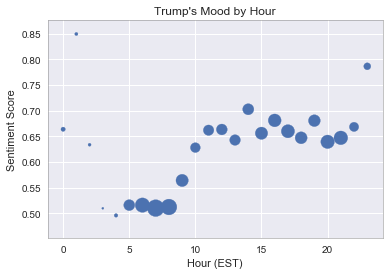

In [278]:
plt.scatter(np.arange(len(X)), X['mean'].values, s=X['count'].values)
plt.xlabel('Hour (EST)')
plt.ylabel('Sentiment Score')
plt.title("Trump's Mood by Hour");

In [396]:
android_description = Y.loc[Y.index.get_level_values('source') == 'Twitter for Android']
iphone_description = Y.loc[Y.index.get_level_values('source') == 'Twitter for iPhone']

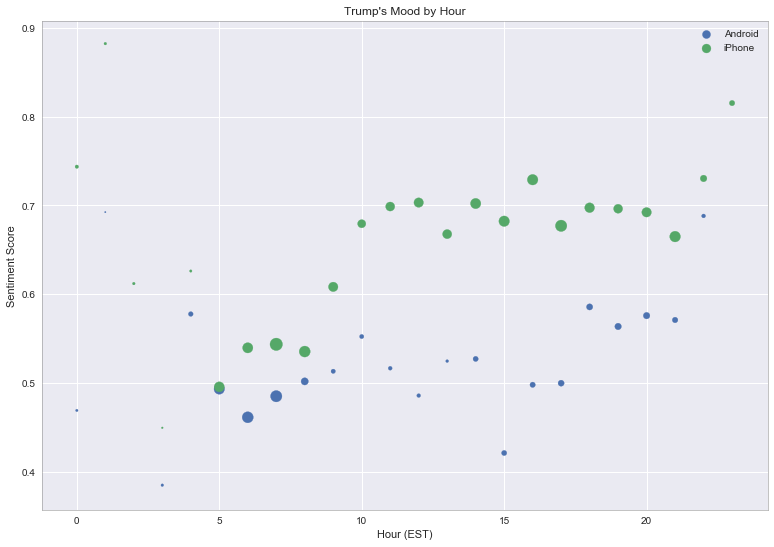

In [411]:
ax, fig = plt.subplots(figsize=(13, 9))
plt.scatter(
    np.arange(len(android_description)),
    android_description['mean'].values,
    s=android_description['count'].values
)
plt.scatter(
    np.arange(len(iphone_description)),
    iphone_description['mean'].values,
    s=iphone_description['count'].values
)
plt.xlabel('Hour (EST)')
plt.ylabel('Sentiment Score')
plt.title("Trump's Mood by Hour");
plt.legend(['Android', 'iPhone']);

In [413]:
android_description

,,count,mean,std,min,25%,50%,75%,max
created_at,source,,,,,,,,
0,Twitter for Android,6.0,0.468866,0.274354,0.054512,0.318764,0.494009,0.697769,0.744626
1,Twitter for Android,2.0,0.692456,0.154195,0.583424,0.637940,0.692456,0.746972,0.801488
2,Twitter for Android,1.0,0.611532,NaN,0.611532,0.611532,0.611532,0.611532,0.611532
4,Twitter for Android,7.0,0.384602,0.326059,0.028104,0.134649,0.274541,0.611526,0.897218
5,Twitter for Android,22.0,0.577573,0.280629,0.096355,0.375547,0.608230,0.824946,0.989381
6,Twitter for Android,110.0,0.493026,0.271840,0.024980,0.253474,0.509528,0.707269,0.978010
7,Twitter for Android,123.0,0.461144,0.249619,0.008119,0.259088,0.444598,0.666687,0.965160
8,Twitter for Android,130.0,0.484890,0.257831,0.003128,0.265399,0.504984,0.676692,0.987201
9,Twitter for Android,53.0,0.501615,0.261083,0.011122,0.274543,0.495462,0.728195,0.975441


In [ ]:
ax, fig = plt.subplots(figsize=(13, 9))


In [258]:
trump_tweets.to_csv('trump_tweet_sentiment.csv')

In [83]:
input_list = ['all', 'this', 'happened', 'more', 'or', 'less', 'this', 'dog']

def find_ngrams(input_list, n):
  return list(set(zip(*[input_list[i:] for i in range(n)])))

In [84]:
for gram in find_ngrams(input_list, 2):
    print(gram)

('this', 'happened')
('more', 'or')
('all', 'this')
('happened', 'more')
('or', 'less')
('less', 'this')
('this', 'dog')


In [85]:
input_list = 'cats and dogs and dogs and cats'

In [86]:
find_ngrams(input_list, 2)

[('a', 'n'),
 ('n', 'd'),
 ('a', 't'),
 ('d', ' '),
 ('o', 'g'),
 ('d', 'o'),
 ('s', ' '),
 ('g', 's'),
 ('c', 'a'),
 (' ', 'a'),
 (' ', 'd'),
 ('t', 's'),
 (' ', 'c')]

In [88]:
sequences = [['all', 'this', 'happened', 'more', 'or', 'less', 'this', 'dog'], ['all', 'this', 'happened', 'more', 'to', 'this', 'dog']]

In [89]:
for seq in sequences:
    seq.extend(list(set(zip(*[seq[i:] for i in range(2)]))))